In [2]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image

# Paths
input_root = "/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset"
output_root = "/kaggle/working/processed_dataset_split"
splits = {'train': 400, 'valid': 50, 'test': 50}
modalities = ["CT", "CXR", "Cough sound"]
classes = ["Healthy", "Lungs Cancer", "Pneumonia", "covid"]

# Create output directories
for split in splits:
    for modality in modalities:
        for cls in classes:
            os.makedirs(os.path.join(output_root, split, modality, cls.replace(" ", "")), exist_ok=True)

# Split & rename images
for modality in modalities:
    for cls in classes:
        cls_clean = cls.replace(" ", "")
        input_folder = os.path.join(input_root, modality, cls_clean)
        all_images = list(Path(input_folder).glob("*.[jp][pn]g"))

        if len(all_images) < 500:
            raise ValueError(f"❌ Not enough images in {input_folder}. Found {len(all_images)}")

        random.shuffle(all_images)
        split_images = {
            'train': all_images[:splits['train']],
            'valid': all_images[splits['train']:splits['train'] + splits['valid']],
            'test': all_images[splits['train'] + splits['valid']:]
        }

        for split, img_paths in split_images.items():
            for idx, img_path in enumerate(img_paths, 1):
                img = Image.open(img_path).convert("RGB")
                new_name = f"{cls_clean}{idx}.jpg"
                save_path = os.path.join(output_root, split, modality, cls_clean, new_name)
                img.save(save_path)



## **There is no image transfer due to running this code before then deleting it by mistake, but I already ran it, and I will provide evidence below.**


In [3]:
!ls /kaggle/working/processed_dataset_split/train 
!ls /kaggle/working/processed_dataset_split


'Cough sound'   CT   CXR
test  train  valid


**Load each modality using ImageDataGenerator**

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# نجهز مولد الصور مع نسبة 20% للـ validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# ---- CT ----
train_ct = datagen.flow_from_directory(
    '/kaggle/working/processed_dataset_split/train/CT',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # لأن عندنا 4 فئات
    subset='training'
)

val_ct = datagen.flow_from_directory(
    '/kaggle/working/processed_dataset_split/train/CT',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# ---- CXR ----
train_cxr = datagen.flow_from_directory(
    '/kaggle/working/processed_dataset_split/train/CXR',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_cxr = datagen.flow_from_directory(
    '/kaggle/working/processed_dataset_split/train/CXR',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# ---- Cough sound ----
train_cough = datagen.flow_from_directory(
    '/kaggle/working/processed_dataset_split/train/Cough sound',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_cough = datagen.flow_from_directory(
    '/kaggle/working/processed_dataset_split/train/Cough sound',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


In [17]:
print(train_ct.class_indices)
print(train_cxr.class_indices)
print(train_cough.class_indices)

{'Healthy': 0, 'LungsCancer': 1, 'Pneumonia': 2, 'covid': 3}
{'Healthy': 0, 'LungsCancer': 1, 'Pneumonia': 2, 'covid': 3}
{'Healthy': 0, 'LungsCancer': 1, 'Pneumonia': 2, 'covid': 3}


**Model Preparation**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# إعداد شكل الصورة وعدد الفئات
img_shape = (224, 224, 3)
num_classes = 4

def build_model():
    """موديل CNN بسيط لتصنيف الصور"""
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=img_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')  # 4 فئات
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


**CT – CXR – Cough Models Training**

In [19]:
# بناء كل موديل
model_ct = build_model()
model_cxr = build_model()
model_cough = build_model()

# تدريب موديل الـ CT
print("\n🩻 Training CT Model...")
history_ct = model_ct.fit(
    train_ct,
    validation_data=val_ct,
    epochs=5,
    verbose=1
)

# تدريب موديل الـ CXR
print("\n🫁 Training CXR Model...")
history_cxr = model_cxr.fit(
    train_cxr,
    validation_data=val_cxr,
    epochs=5,
    verbose=1
)

# تدريب موديل الـ Cough sound
print("\n🎤 Training Cough Model...")
history_cough = model_cough.fit(
    train_cough,
    validation_data=val_cough,
    epochs=5,
    verbose=1
)


🩻 Training CT Model...
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5350 - loss: 2.5049 - val_accuracy: 0.8781 - val_loss: 0.3197
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8877 - loss: 0.3001 - val_accuracy: 0.8969 - val_loss: 0.2830
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8992 - loss: 0.2563 - val_accuracy: 0.8938 - val_loss: 0.2287
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9415 - loss: 0.1600 - val_accuracy: 0.9187 - val_loss: 0.2115
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9572 - loss: 0.1257 - val_accuracy: 0.9312 - val_loss: 0.2201

🫁 Training CXR Model...
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.4313 - loss: 3.6297 - val_accuracy: 0.8813 - val_loss: 0.3373
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8298 - loss: 0.4244 - val_accuracy: 0.8438 - val_loss: 0.3555
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.863

**Images Model accuracy**

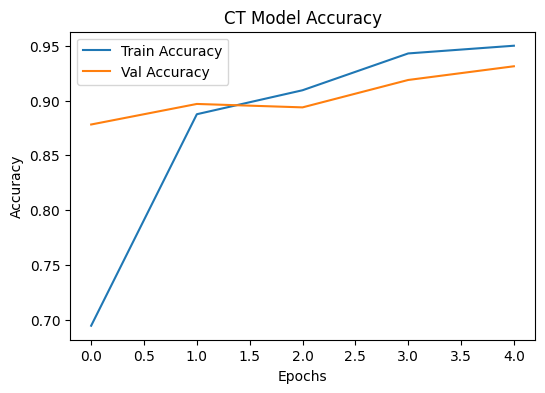

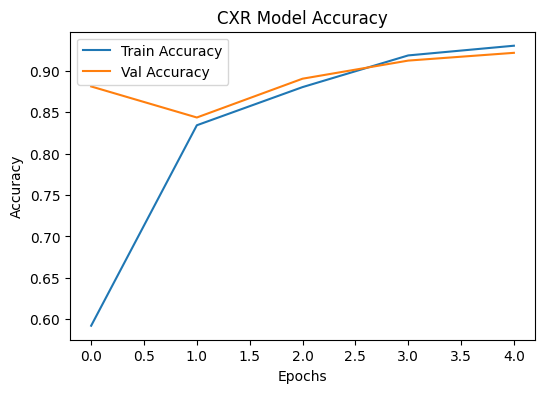

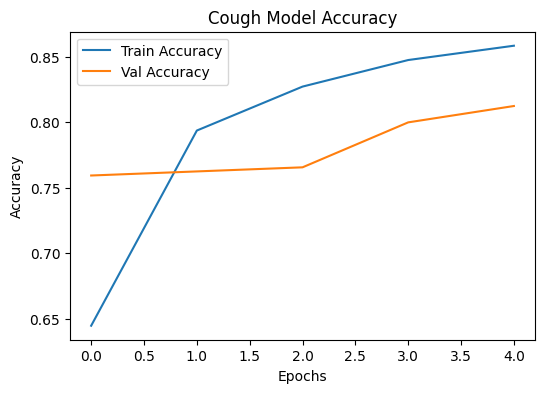

In [20]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_ct, "CT Model Accuracy")
plot_history(history_cxr, "CXR Model Accuracy")
plot_history(history_cough, "Cough Model Accuracy")

**Intermediate Fusion Model**

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

# =============== CNN Model Builder ===============
def build_cnn(input_shape=(224, 224, 3)):
    inp = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu')(inp)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    return Model(inputs=inp, outputs=x)

# =============== Build 3 CNNs for CT, CXR, and Cough ===============
cnn_ct = build_cnn()
cnn_cxr = build_cnn()
cnn_cough = build_cnn()

# =============== Merge the 3 models ===============
merged = concatenate([cnn_ct.output, cnn_cxr.output, cnn_cough.output])

# Add fully connected layers after fusion
x = Dense(256, activation='relu')(merged)
x = Dropout(0.4)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes: Healthy, Covid, Pneumonia, LungsCancer

fusion_model = Model(inputs=[cnn_ct.input, cnn_cxr.input, cnn_cough.input], outputs=x)

# =============== Compile the model ===============
fusion_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

fusion_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 222, 222,  │        896 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 222, 222,  │        896 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 222, 222,  │        896 │ input_layer_17[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 111, 111,  │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 111, 111,  │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 111, 111,  │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_25… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_28… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_31… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 54, 54,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 54, 54,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 54, 54,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_26… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 52, 52,    │     73,856 │ max_pooling2d_29

 Total params: 33,606,468 (128.20 MB)

 Trainable params: 33,606,468 (128.20 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [27]:
x, y = next(train_ct)
print(y[:5])
print(y.shape)

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
(32, 4)


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# ----- الخطوة 1: نحدد الـ inputs -----
input_ct = Input(shape=(224, 224, 3), name="ct_input")
input_cxr = Input(shape=(224, 224, 3), name="cxr_input")
input_cough = Input(shape=(224, 224, 3), name="cough_input")

# ----- الخطوة 2: نمررهم على الـ feature extractors -----
feat_ct = base_ct(input_ct)
feat_cxr = base_cxr(input_cxr)
feat_cough = base_cough(input_cough)

# ----- الخطوة 3: ندمج الميزات -----
merged = Concatenate()([feat_ct, feat_cxr, feat_cough])

# ----- الخطوة 4: الطبقات النهائية -----
x = Dense(256, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)  # ✅ 4 فئات بدلاً من 1

# ----- الخطوة 5: بناء الموديل -----
fusion_model = Model(inputs=[input_ct, input_cxr, input_cough], outputs=output)

# ----- الخطوة 6: Compile -----
fusion_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fusion_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cxr_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cough_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 128)       │ 23,907,392 │ ct_input[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 128)       │ 23,907,392 │ cxr_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ (None, 128)       │ 23,907,392 │ cough_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 384)       │          0 │ functional_6[1][… │
│ (Concatenate)       │                   │            │ functional_7[1][… │
│                     │                   │            │ functional_8[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │     98,560 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     32,896 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 4)         │        516 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,854,148 (274.10 MB)

 Trainable params: 71,854,148 (274.10 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import tensorflow as tf

# نربط الـ Generators في Dataset واحد
def combined_generator(gen_ct, gen_cxr, gen_cough):
    while True:
        x_ct, y = next(gen_ct)
        x_cxr, _ = next(gen_cxr)
        x_cough, _ = next(gen_cough)
        yield ([x_ct, x_cxr, x_cough], y)

train_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(train_ct, train_cxr, train_cough),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(val_ct, val_cxr, val_cough),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )
)

In [32]:
import tensorflow as tf

# 🔹 دالة تولد البيانات بشكل متزامن من الـ 3 Generators
def combined_generator(gen_ct, gen_cxr, gen_cough):
    while True:
        x_ct, y_ct = next(gen_ct)
        x_cxr, y_cxr = next(gen_cxr)
        x_cough, y_cough = next(gen_cough)

        # كلهم لهم نفس الlabels
        y = y_ct

        # استخدم tuple مش list (عشان TensorFlow يتقبلها)
        yield (x_ct, x_cxr, x_cough), y


# 🔹 إنشاء Generators للتدريب والاختبار
train_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(train_ct, train_cxr, train_cough),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: combined_generator(val_ct, val_cxr, val_cough),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )
)

# 🔹 تدريب الموديل
history = fusion_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    steps_per_epoch=len(train_ct),
    validation_steps=len(val_ct)
)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.3009 - loss: 1.5684 - val_accuracy: 0.5063 - val_loss: 1.2162
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.4642 - loss: 1.1940 - val_accuracy: 0.8188 - val_loss: 0.7506
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.6010 - loss: 0.9152 - val_accuracy: 0.8469 - val_loss: 0.5279
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.6774 - loss: 0.7297 - val_accuracy: 0.8500 - val_loss: 0.4551
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.7634 - loss: 0.5591 - val_accuracy: 0.8562 - val_loss: 0.3639
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7837 - loss: 0.5088 - val_accuracy: 0.8531 - val_loss: 0.3435
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8267 - loss: 0.4456 - val_accuracy: 0.8813 - val_loss: 0.2963
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8231 - loss: 0.4331 - val_accuracy: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9321 - loss: 0.2106
✅ Validation Accuracy: 0.9187
📉 Validation Loss: 0.2274


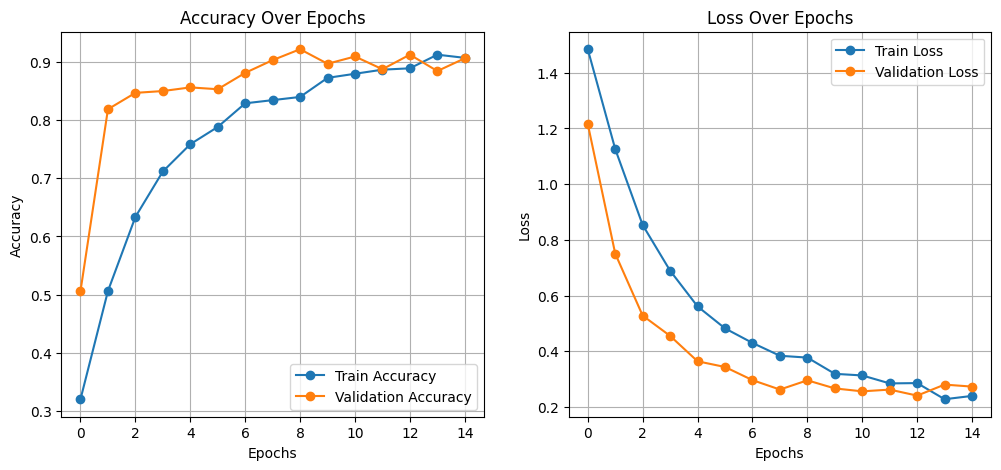

In [33]:
import matplotlib.pyplot as plt

# 🔹 تقييم الموديل على بيانات التحقق (validation)
val_loss, val_acc = fusion_model.evaluate(val_dataset, steps=len(val_ct))
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")

# 🔹 عرض منحنيات التدريب
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

✅ Accuracy: 0.90625
🎯 Precision: 0.9112809158099013
📈 Recall: 0.90625
🏆 F1-Score: 0.9065671311572706

📊 Classification Report:
               precision    recall  f1-score   support

 LungsCancer       0.90      0.78      0.83        80
     Healthy       0.99      0.96      0.97        80
       covid       0.99      1.00      0.99        80
   Pneumonia       0.77      0.89      0.83        80

    accuracy                           0.91       320
   macro avg       0.91      0.91      0.91       320
weighted avg       0.91      0.91      0.91       320



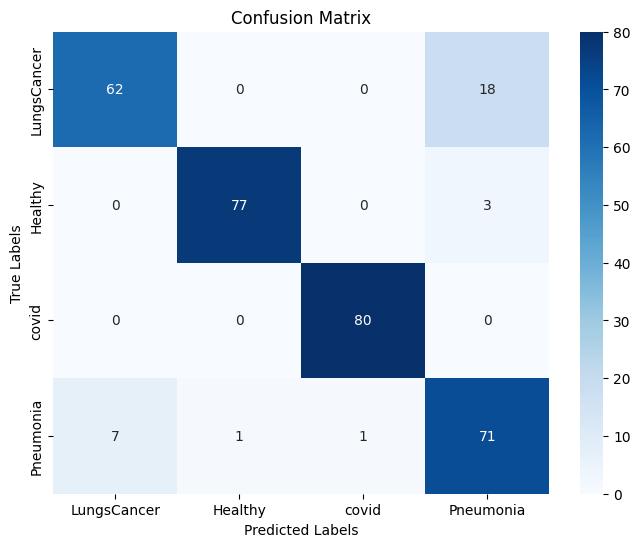

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 أسماء الأصناف (لازم تكون بنفس ترتيب الأصناف اللي استخدمتها في التدريب)
class_names = ['LungsCancer', 'Healthy', 'covid', 'Pneumonia']

# 🔹 الحصول على التوقعات والحقائق
y_true = []
y_pred = []

# نمرّ على كل batch في الـ validation
for (x1, y) in val_ct:
    # توقف بعد عدد الخطوات المحدد
    if len(y_true) >= len(val_ct) * val_ct.batch_size:
        break

    # التوقع من الموديل (نفس الصورة بتتكرر للـ 3 inputs)
    preds = fusion_model.predict([x1, x1, x1], verbose=0)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# تحويلهم لمصفوفات numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 🔹 حساب المقاييس
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("✅ Accuracy:", acc)
print("🎯 Precision:", prec)
print("📈 Recall:", rec)
print("🏆 F1-Score:", f1)
print("\n📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# 🔹 رسم مصفوفة الالتباس (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
print(os.listdir("/kaggle/working/processed_dataset_split/train/CT"))


['LungsCancer', 'Healthy', 'covid', 'Pneumonia']
